# Lesson 5

## Purpose

The goal of this Lesson is to look at more advanced features of the matching software

* Multiple experiments
* Multiple score
* Scores that apply to only a subset of the data
* Fractionation
* Multiple components
* Per-component parameters

## Standard imports

In [1]:
#from IPython.core.display import display, HTML
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

#Python path library support
from pathlib import Path

#python numeric library
import numpy

#python math library
import math

#scientific library for python
import scipy

#pandas is python library for data analysis
import pandas

#addict is a library that makes it easier to create nested dictionaries
from addict import Dict

#json is a standard text based format and it used in CADETMatch for the configuration file
import json

#python plotting library
import matplotlib.pyplot as plt

#cadet python interface
from cadet import Cadet

#jupyter widget support
from ipywidgets import interact
import ipywidgets as widgets

from CADETMatch.jupyter import Match

#This is just a support function to make running the examples a bit easier later
def deleteResultDir(path):
    #This is to try and make sure that only an actual result directory can be removed
    #And only if no other files have been added to the directory, just in case
    if not path.exists():
        return
    allowed = {'evo', 'grad', 'log', 'mcmc', 'meta', 'misc', 'progress', 
               'space', 'error.csv', 'result.h5', 'progress.csv'}
    allowed.add(match.csv)
    allowed.add(match_file.name)
    okayToRemove = False
    for child in path.iterdir():
        if child.name not in allowed:
            break
    else:
        okayToRemove = True
    if okayToRemove:
        import shutil
        shutil.rmtree(path)
        
def fractionate(start_seq, stop_seq, times, values):
    temp = []
    for (start, stop) in zip(start_seq, stop_seq):
        selected = (times >= start) & (times <= stop)
        local_times = times[selected]
        local_values = values[selected]
        
        stop = local_times[-1]
        start = local_times[0]

        temp.append(numpy.trapz(local_values, local_times)/ (stop - start))
    return numpy.array(temp)

In [2]:
#put in the path to the bin folder
cadet_bin_path = Path(r"C:\Users\kosh_000\cadet_build\CADET\VCPKG\bin")

cadet_path = cadet_bin_path / "cadet-cli.exe"

if cadet_path.exists():
    print("CADET was found. Continue to the next step.")
    Cadet.cadet_path = cadet_path.as_posix()
else:
    print('CADET could not be found. Please check the bin path')
    
print(cadet_path.as_posix())

CADET was found. Continue to the next step.
C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe


In [3]:
#set this to a directory on your computer where the cadet tutorial files can be saved
cadet_tutorial = Path('F:/temp/cadet_tutorial')
lesson_1 = cadet_tutorial / "lesson_1"
lesson_2 = cadet_tutorial / "lesson_2"
lesson_3 = cadet_tutorial / "lesson_3"
lesson_4 = cadet_tutorial / "lesson_4"
lesson_5 = cadet_tutorial / "lesson_5"
lesson_5.mkdir(exist_ok = True, parents=True)

# Scoring on part of a chromatogram
Sometimes there is noise in your system or some other peak in your system that you know the cause of but you don't want the matching system to look at. You could even have a high molecular weight species that you don't want to model. For these cases you can apply the score to just a section of the chromatogram.

I am making a copy of our existing dextran example from Lesson 1 and then adding a small peak to it before the main peak and then we will look at how the fitting works.

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_5/slice/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


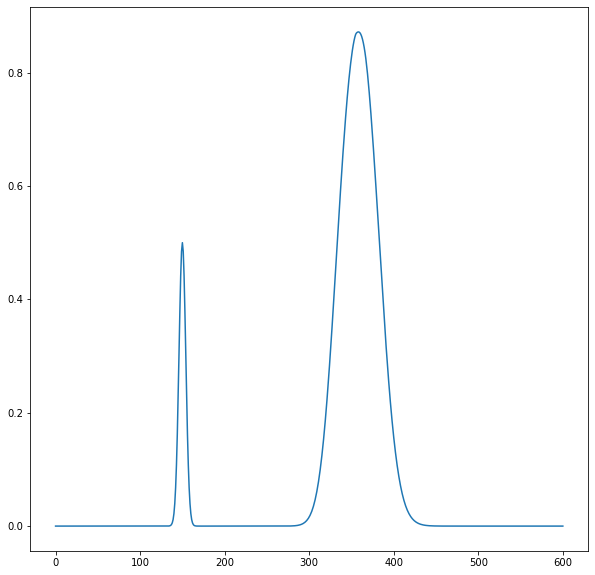

In [4]:
slice_dir = lesson_5 / "slice"
slice_dir.mkdir(exist_ok = True)

simple = Cadet()

#give a filename for where the simulation should be saved
simple.filename = (lesson_1 / "simple_example" / 'example.h5').as_posix()

simple.load()

simple.filename = (slice_dir / 'example.h5').as_posix()

#save the simulation
simple.save()

#run the simulation
data = simple.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    simple.load()
    
    times = simple.root.output.solution.solution_times
    values = simple.root.output.solution.unit_002.solution_outlet_comp_000
    
    #add a small peak to values between 100 and 200 seconds
    
    selected = (times >= 100) & (times <= 200)
    values[selected] = scipy.signal.gaussian(101, 4) * 0.5
    
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times,
        values)
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times,
                        values]).transpose()
    data.to_csv((slice_dir / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Look at the simple match
We will first use the example from Lesson 4 to match this data set without any slicing and see what happens

In [5]:
match = Dict()
match.CADETPath = cadet_path.as_posix()
match.baseDir = slice_dir.as_posix()
match.resultsDir = 'fit_nsga3'
match.csv = 'fit_results.csv'
match.checkpointFile = "check"
match.stopAverage = 1.1
match.stopBest = 1.1
match.gradCheck = 1.1
match.gradVector = 1
match.searchMethod = 'NSGA3'
match.mutationRate = 1.0
match.crossoverRate = 1.0
match.generations = 1000
match.population = 12
match.minPopulation = 12
match.maxPopulation = 12
match.finalGradRefinement = 1
match.stallGenerations = 10

parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_001/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-6

parameter2 = Dict()
parameter2.transform = 'norm'
parameter2.component = -1
parameter2.bound = -1
parameter2.location = "/input/model/unit_001/COL_POROSITY"
parameter2.min = 0.2
parameter2.max = 0.5

match.parameters = [parameter1, parameter2]

experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'

experiment1.features = [feature1,]

match.experiments = [experiment1,]

match_file = slice_dir / 'example_nsga3_simple.json'

with (match_file).open('w') as json_file:
    json.dump(match.to_dict(), json_file, indent='\t')

## Run parameter estimation on the full chromatogram

Your results are located at F:/temp/cadet_tutorial/lesson_5/slice/fit_nsga3 


[2019-09-30 17:00:02,811] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-09-30 17:00:02,811] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-09-30 17:00:02,811] launcher  INFO    Worker distribution: 

[2019-09-30 17:00:02,811] launcher  INFO       127.0.0.1:	11 + origin

[2019-09-30 17:00:08,184] util      (b'127.0.0.1:63461') INFO    Generation: -1 	Population: 24 	Average Score: 0.828 	Best: 0.959 	Minimum Score: 0.696 	Best: 0.939 	Product Score: 0.805 	Best: 0.959

[2019-09-30 17:00:09,121] util      (b'127.0.0.1:63461') INFO    Generation: 0 	Population: 24 	Average Score: 0.886 	Best: 0.959 	Minimum Score: 0.81 	Best: 0.939 	Product Score: 0.882 	Best: 0.959

[2019-09-30 17:00:09,966] util      (b'127.0.0.1:63461') INFO    Generation: 1 	Population: 24 	Average Score:

[2019-09-30 17:00:41,962] util      (b'127.0.0.1:63461') INFO    Generation: 38 	Population: 24 	Average Score: 0.926 	Best: 0.962 	Minimum Score: 0.897 	Best: 0.945 	Product Score: 0.925 	Best: 0.962

[2019-09-30 17:00:42,742] util      (b'127.0.0.1:63461') INFO    Generation: 39 	Population: 24 	Average Score: 0.926 	Best: 0.962 	Minimum Score: 0.897 	Best: 0.945 	Product Score: 0.926 	Best: 0.962

[2019-09-30 17:00:43,734] util      (b'127.0.0.1:63461') INFO    Generation: 40 	Population: 24 	Average Score: 0.924 	Best: 0.962 	Minimum Score: 0.894 	Best: 0.945 	Product Score: 0.924 	Best: 0.962

[2019-09-30 17:00:44,469] util      (b'127.0.0.1:63461') INFO    Generation: 41 	Population: 24 	Average Score: 0.924 	Best: 0.962 	Minimum Score: 0.894 	Best: 0.945 	Product Score: 0.924 	Best: 0.962

[2019-09-30 17:00:45,360] util      (b'127.0.0.1:63461') INFO    Generation: 42 	Population: 24 	Average Score: 0.924 	Best: 0.962 	Minimum Score: 0.892 	Best: 0.945 	Product Score: 0.923 	Bes

[2019-09-30 17:01:15,266] util      (b'127.0.0.1:63461') INFO    Generation: 79 	Population: 24 	Average Score: 0.923 	Best: 0.962 	Minimum Score: 0.891 	Best: 0.945 	Product Score: 0.923 	Best: 0.962

[2019-09-30 17:01:16,020] util      (b'127.0.0.1:63461') INFO    Generation: 80 	Population: 24 	Average Score: 0.923 	Best: 0.962 	Minimum Score: 0.891 	Best: 0.945 	Product Score: 0.923 	Best: 0.962

[2019-09-30 17:01:16,786] util      (b'127.0.0.1:63461') INFO    Generation: 81 	Population: 24 	Average Score: 0.923 	Best: 0.962 	Minimum Score: 0.891 	Best: 0.945 	Product Score: 0.923 	Best: 0.962

[2019-09-30 17:01:17,549] util      (b'127.0.0.1:63461') INFO    Generation: 82 	Population: 24 	Average Score: 0.923 	Best: 0.962 	Minimum Score: 0.891 	Best: 0.945 	Product Score: 0.923 	Best: 0.962

[2019-09-30 17:01:18,388] util      (b'127.0.0.1:63461') INFO    Generation: 83 	Population: 24 	Average Score: 0.924 	Best: 0.962 	Minimum Score: 0.893 	Best: 0.945 	Product Score: 0.923 	Bes

[2019-09-30 17:02:17,868] generate_corner_graphs (b'127.0.0.1:65111') INFO    graphing directory F:\temp\cadet_tutorial\lesson_5\slice

[2019-09-30 17:02:17,868] generate_corner_graphs (b'127.0.0.1:65111') INFO    plotting corner plots

[2019-09-30 17:02:17,875] generate_corner_graphs (b'127.0.0.1:65111') INFO    graphing remove 0 points

[2019-09-30 17:02:17,917] loggerwriter (b'127.0.0.1:65111') WARNING WARNING:root:Too few points to create valid contours



[2019-09-30 17:02:21,605] loggerwriter (b'127.0.0.1:65111') WARNING WARNING:root:Too few points to create valid contours



[2019-09-30 17:02:25,136] loggerwriter (b'127.0.0.1:65111') WARNING WARNING:root:Too few points to create valid contours



[2019-09-30 17:02:28,624] loggerwriter (b'127.0.0.1:65111') WARNING WARNING:root:Too few points to create valid contours



[2019-09-30 17:02:31,807] loggerwriter (b'127.0.0.1:65111') WARNING WARNING:root:Too few points to create valid contours



[2019-09-30 17:02:34,884] loggerwriter 

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
9,Mon Sep 30 17:01:30 2019,4d9576a63aa0cd4164eb3dd8ac6ed982,EVO,NaN,1.000000e-06,0.2,0.939656,0.985319,0.962216,0.939656,0.962487,1.668305


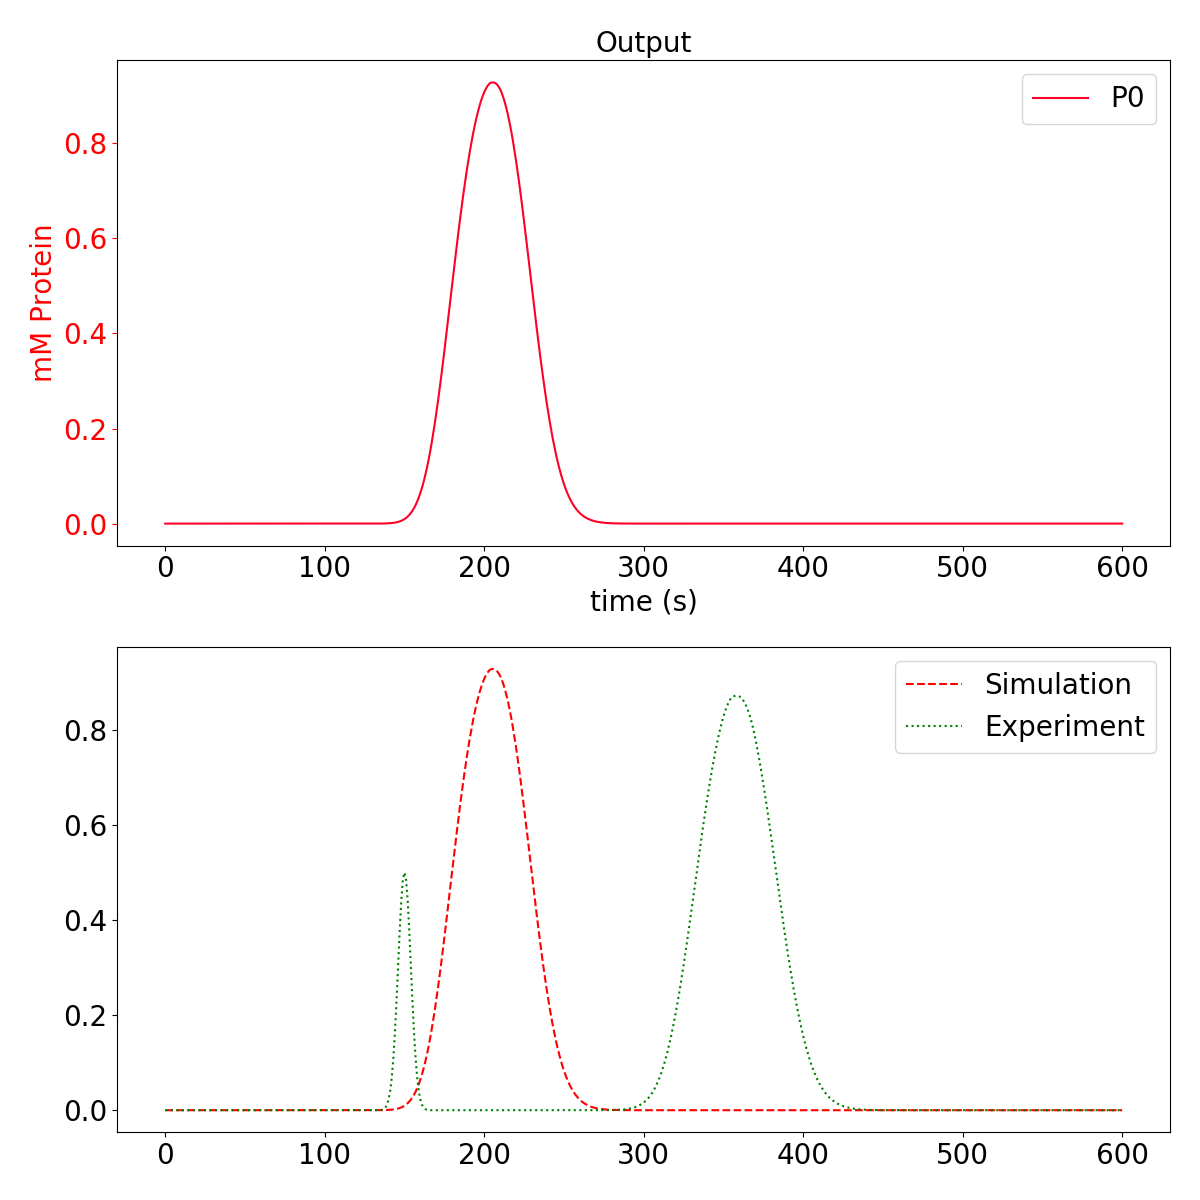

Best item ff9729dc653e2d0f783250af95a246f9 for meta score(s) Min Score , SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
0,Mon Sep 30 17:00:38 2019,ff9729dc653e2d0f783250af95a246f9,EVO,NaN,9.998494e-07,0.216076,0.945057,0.946096,0.945577,0.945057,0.945577,1.771523


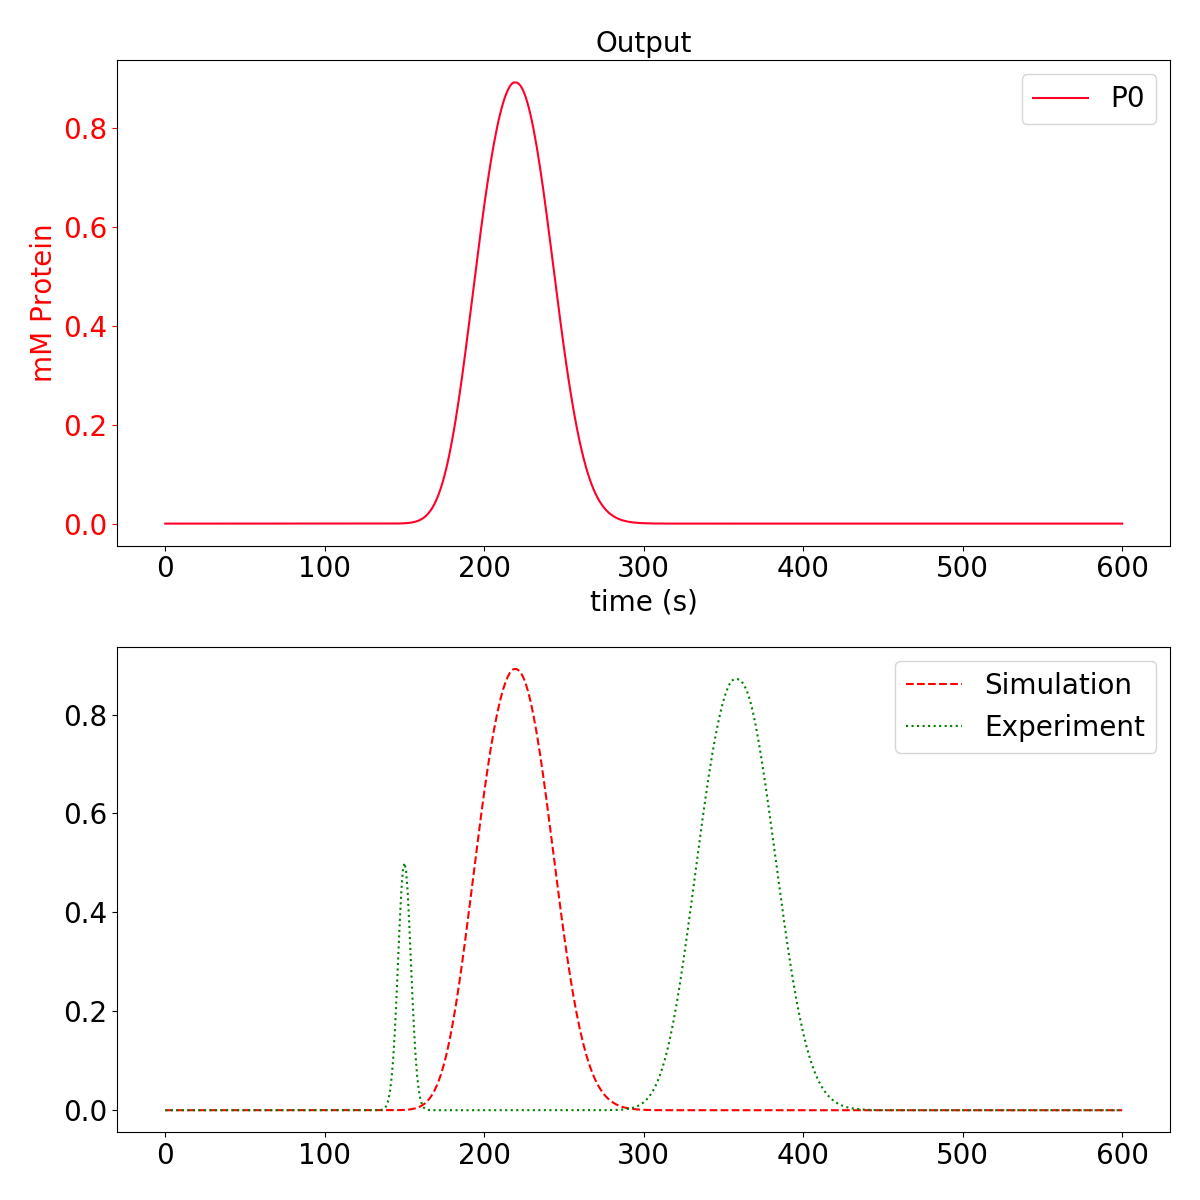

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.00e-06   error: 80%
COL_POROSITY Comp:-1 Bound:-1 = 2.00e-01   error: 85%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.00e-06   error: 80%
COL_POROSITY Comp:-1 Bound:-1 = 2.16e-01   error: 71%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.00e-06   error: 80%
COL_POROSITY Comp:-1 Bound:-1 = 2.00e-01   error: 85%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 1.00e-06   error: 80%
COL_POROSITY Comp:-1 Bound:-1 = 2.16e-01   error: 71%




In [6]:
sim_simple = Match(match_file.as_posix())

resultDirSimple = Path(match.baseDir) / match.resultsDir
print("Your results are located at", resultDirSimple.as_posix(), '\n\n')

#If you want to delete the fitting process to start over remove the # from the next line and re-run this cell
deleteResultDir(resultDirSimple)

sim_simple.start_sim()

sim_simple.plot_best()
best ,score, best_score = sim_simple.get_best()
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])
for key,value in best_score.items():
    print("Method: %s" % key)
    for name, val, true_value in zip(sim_simple.cache.parameter_headers, value, true_values):
        print("%s = %.2e   error: %.2g%%" % (name, val, numpy.abs(val-true_value)/val*100))
    print('\n')

## Create a configuration file for a slice

Features inside experiments take an optional start and stop argument. If you provide start and stop the score will only apply inside that region.

```json
{
  "name": "Pulse",
  "type": "DextranShape"
}```

```python
feature = Dict()
feature.name = "Pulse"
feature.type = "DextranShape"``` 

Gets changed to

```json
{
  "name": "Pulse",
  "type": "DextranShape"
  "start": 250,
  "stop": 450
}```

```python
feature = Dict()
feature.name = "Pulse"
feature.type = "DextranShape"
feature.start = 250
feature.stop = 450``` 

In [7]:
match_slice = Dict(match.copy())
match_slice.CADETPath = cadet_path.as_posix()
match_slice.baseDir = slice_dir.as_posix()
match_slice.resultsDir = 'fit_nsga3_slice'


experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'
feature1.start = 250
feature1.stop = 450

experiment1.features = [feature1,]

match_slice.experiments = [experiment1,]

match_file = slice_dir / 'example_nsga3_slice.json'

with (match_file).open('w') as json_file:
    json.dump(match_slice.to_dict(), json_file, indent='\t')

## Run parameter estimation on a slice

Your results are located at F:/temp/cadet_tutorial/lesson_5/slice/fit_nsga3_slice 


[2019-09-30 17:02:40,489] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-09-30 17:02:40,489] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-09-30 17:02:40,489] launcher  INFO    Worker distribution: 

[2019-09-30 17:02:40,489] launcher  INFO       127.0.0.1:	11 + origin

[2019-09-30 17:02:46,000] util      (b'127.0.0.1:50562') INFO    Generation: -1 	Population: 24 	Average Score: 0.876 	Best: 0.99 	Minimum Score: 0.757 	Best: 0.985 	Product Score: 0.845 	Best: 0.99

[2019-09-30 17:02:46,877] util      (b'127.0.0.1:50562') INFO    Generation: 0 	Population: 24 	Average Score: 0.878 	Best: 0.99 	Minimum Score: 0.759 	Best: 0.985 	Product Score: 0.851 	Best: 0.99

[2019-09-30 17:02:47,706] util      (b'127.0.0.1:50562') INFO    Generation: 1 	Population: 24 	Average Sco

[2019-09-30 17:03:18,810] util      (b'127.0.0.1:50562') INFO    Generation: 39 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.996 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-09-30 17:03:19,578] util      (b'127.0.0.1:50562') INFO    Generation: 40 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.996 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-09-30 17:03:20,369] util      (b'127.0.0.1:50562') INFO    Generation: 41 	Population: 24 	Average Score: 0.991 	Best: 1 	Minimum Score: 0.981 	Best: 1 	Product Score: 0.991 	Best: 1

[2019-09-30 17:03:21,173] util      (b'127.0.0.1:50562') INFO    Generation: 42 	Population: 24 	Average Score: 0.991 	Best: 1 	Minimum Score: 0.981 	Best: 1 	Product Score: 0.991 	Best: 1

[2019-09-30 17:03:21,981] util      (b'127.0.0.1:50562') INFO    Generation: 43 	Population: 24 	Average Score: 0.991 	Best: 1 	Minimum Score: 0.981 	Best: 1 	Product Score: 0.991 	Best: 1

[2019-09-30 17:03:22,830] util      (b'127.0.0.1:5

[2019-09-30 17:03:58,251] util      (b'127.0.0.1:50562') INFO    Generation: 85 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-09-30 17:03:59,210] util      (b'127.0.0.1:50562') INFO    Generation: 86 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-09-30 17:04:00,247] util      (b'127.0.0.1:50562') INFO    Generation: 87 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-09-30 17:04:01,200] util      (b'127.0.0.1:50562') INFO    Generation: 88 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-09-30 17:04:02,085] util      (b'127.0.0.1:50562') INFO    Generation: 89 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-09-30 17:04:03,003] util      (b'127.0.0.1:50562') INFO    Generation: 90 	Population: 24 	Average Score

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
1,Mon Sep 30 17:04:17 2019,a22522e48595c2f8544d6ff9ee2a66cd,GRAD,NaN,1.999992e-07,0.37,1.0,1.0,1.0,1.0,1.0,5.166528e-15


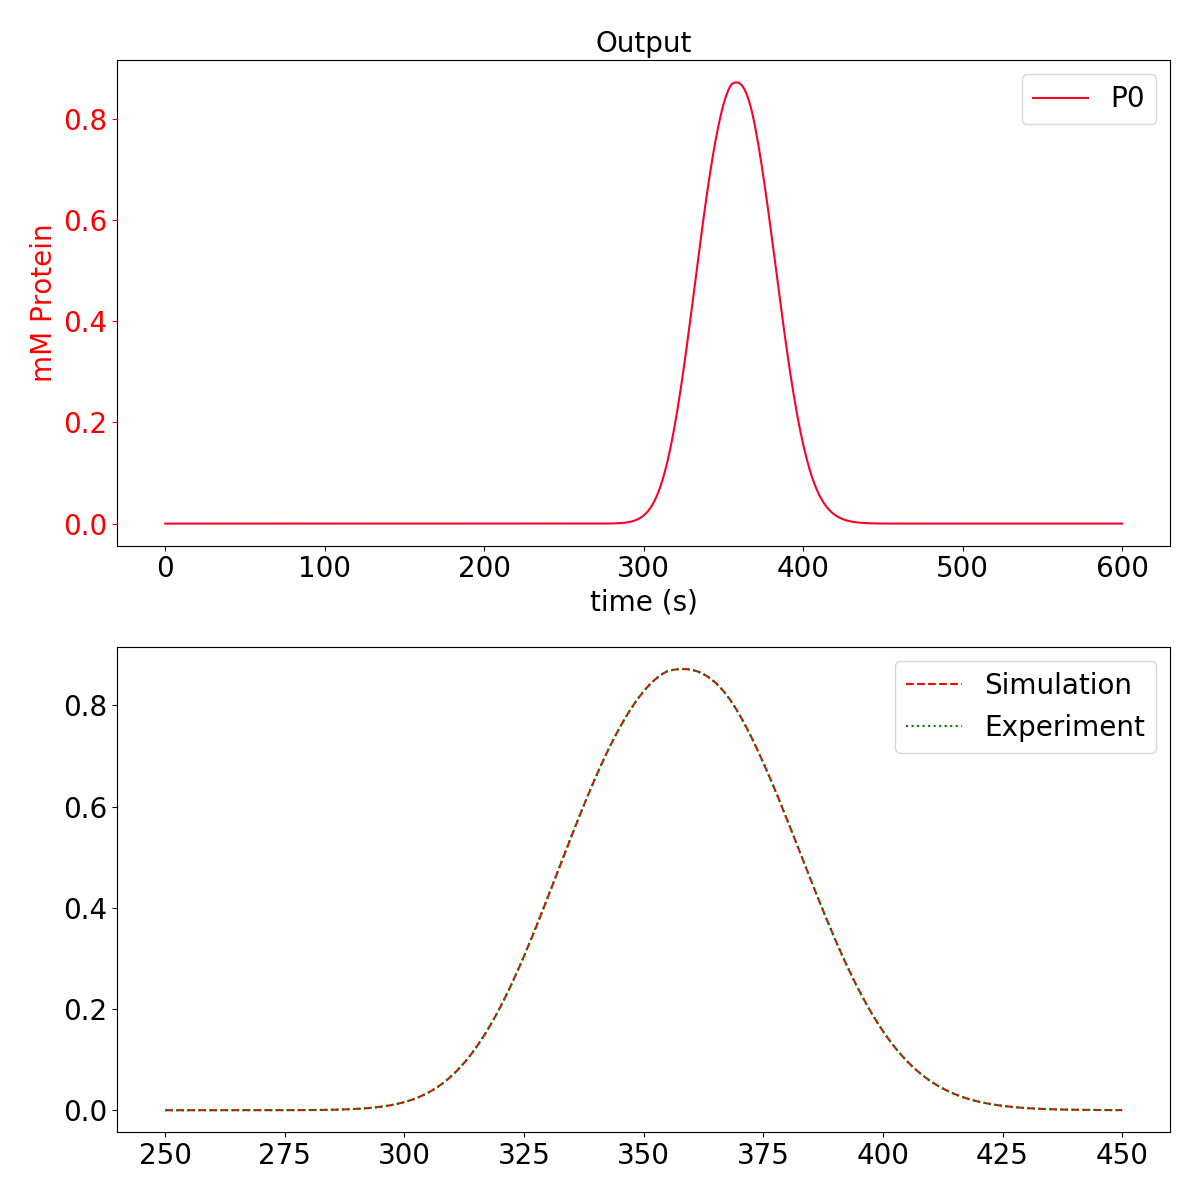

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.0004%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 1.7e-05%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.0004%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 1.7e-05%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.0004%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 1.7e-05%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.0004%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 1.7e-05%




In [8]:
sim_slice = Match(match_file.as_posix())

resultDirSlice = Path(match_slice.baseDir) / match_slice.resultsDir
print("Your results are located at", resultDirSlice.as_posix(), '\n\n')

#If you want to delete the fitting process to start over remove the # from the next line and re-run this cell
deleteResultDir(resultDirSlice)

sim_slice.start_sim()

sim_slice.plot_best()
best ,score, best_score = sim_slice.get_best()
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])
for key,value in best_score.items():
    print("Method: %s" % key)
    for name, val, true_value in zip(sim_slice.cache.parameter_headers, value, true_values):
        print("%s = %.2e   error: %.2g%%" % (name, val, numpy.abs(val-true_value)/val*100))
    print('\n')

# Multiple experiments
As the model becomes more complex it can require multiple experiments in order to obtain a unique answer. For fitting the Steric-Mass-Action isotherm usually 2-3 gradients + breakthrough is necessary. Multiple experiments are also useful when you have errors in your system

In this case we will create another variant of the Dextran pulse for fitting. For the purposes of the workshop we will just change the length of the column.

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_5/multiple_experiments/example_1.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully
CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_5/multiple_experiments/example_2.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


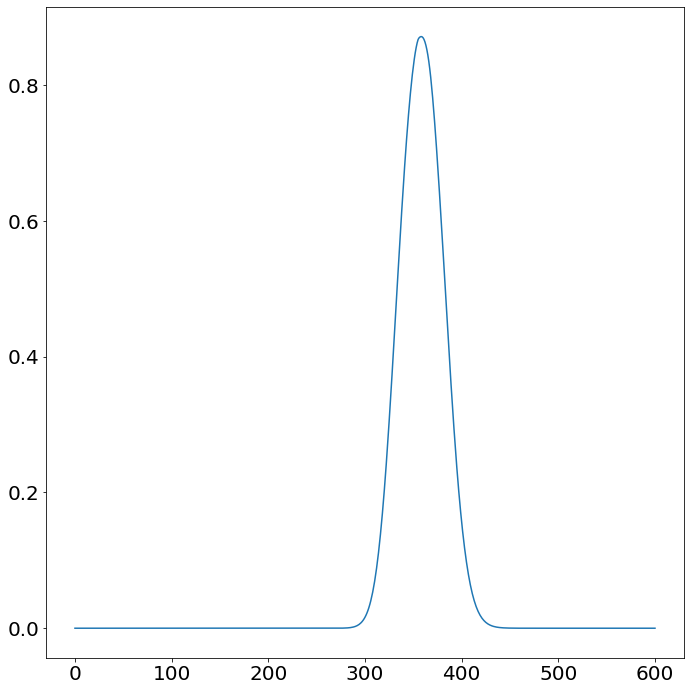

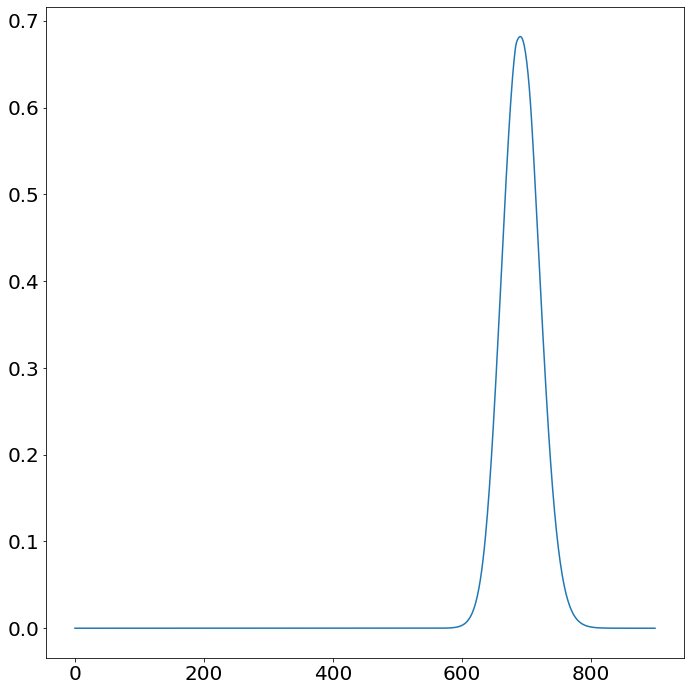

In [9]:
multiple_dir = lesson_5 / "multiple_experiments"
multiple_dir.mkdir(exist_ok = True)

simple = Cadet()

#give a filename for where the simulation should be saved
simple.filename = (lesson_1 / "simple_example" / 'example.h5').as_posix()

simple.load()

simple.filename = (multiple_dir / 'example_1.h5').as_posix()

#save the simulation
simple.save()

#run the simulation
data = simple.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    simple.load()
    
    times = simple.root.output.solution.solution_times
    values = simple.root.output.solution.unit_002.solution_outlet_comp_000
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times,
        values)
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times,
                        values]).transpose()
    data.to_csv((multiple_dir / 'example_1.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")
    
    
    
simple = Cadet()

#give a filename for where the simulation should be saved
simple.filename = (lesson_1 / "simple_example" / 'example.h5').as_posix()

simple.load()

simple.filename = (multiple_dir / 'example_2.h5').as_posix()

simple.root.input.model.unit_001.col_length = simple.root.input.model.unit_001.col_length * 2
simple.root.input.solver.sections.section_times = [0.0, 50.0, 900.0]
simple.root.input.solver.user_solution_times = numpy.linspace(0, 900, 901)

#save the simulation
simple.save()

#run the simulation
data = simple.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    simple.load()
    
    times = simple.root.output.solution.solution_times
    values = simple.root.output.solution.unit_002.solution_outlet_comp_000
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times,
        values)
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times,
                        values]).transpose()
    data.to_csv((multiple_dir / 'example_2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create a configuration file

We are estimating one set of parameters for two experiments. Most of the file stays exactly the same and we just have to add two experiments.

The only thing we need to do is add another experiment and we can use the same score for this new experiment as the first experiment.

In [10]:
match_multiple = Dict(match.copy())
match_multiple.CADETPath = cadet_path.as_posix()
match_multiple.baseDir = multiple_dir.as_posix()
match_multiple.resultsDir = 'fit_nsga3_multiple'


experiment1 = Dict()
experiment1.csv = "example_1.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example_1.h5"
experiment1.name = "exp1"
experiment1.timeout = 30.0

experiment2 = Dict()
experiment2.csv = "example_2.csv"
experiment2.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment2.HDF5 = "example_2.h5"
experiment2.name = "exp2"
experiment2.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'

experiment1.features = [feature1,]

experiment2.features = [feature1,]

match_multiple.experiments = [experiment1, experiment2]

match_file = multiple_dir / 'example_nsga3_multiple.json'

with (match_file).open('w') as json_file:
    json.dump(match_multiple.to_dict(), json_file, indent='\t')

## Run parameter estimation
Now that we have our new experimental setup we can run the matching process.

Your results are located at F:/temp/cadet_tutorial/lesson_5/multiple_experiments/fit_nsga3_multiple 


[2019-09-30 17:04:57,072] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-09-30 17:04:57,072] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-09-30 17:04:57,072] launcher  INFO    Worker distribution: 

[2019-09-30 17:04:57,072] launcher  INFO       127.0.0.1:	11 + origin

[2019-09-30 17:05:04,725] util      (b'127.0.0.1:63909') INFO    Generation: -1 	Population: 24 	Average Score: 0.939 	Best: 0.99 	Minimum Score: 0.874 	Best: 0.986 	Product Score: 0.935 	Best: 0.99

[2019-09-30 17:05:07,072] util      (b'127.0.0.1:63909') INFO    Generation: 0 	Population: 24 	Average Score: 0.966 	Best: 0.99 	Minimum Score: 0.93 	Best: 0.986 	Product Score: 0.964 	Best: 0.99

[2019-09-30 17:05:09,505] util      (b'127.0.0.1:63909') INFO    Generation: 1 	Population

[2019-09-30 17:06:21,550] util      (b'127.0.0.1:63909') INFO    Generation: 39 	Population: 24 	Average Score: 0.999 	Best: 1 	Minimum Score: 0.998 	Best: 1 	Product Score: 0.999 	Best: 1

[2019-09-30 17:06:23,330] util      (b'127.0.0.1:63909') INFO    Generation: 40 	Population: 24 	Average Score: 0.999 	Best: 1 	Minimum Score: 0.998 	Best: 1 	Product Score: 0.999 	Best: 1

[2019-09-30 17:06:25,013] util      (b'127.0.0.1:63909') INFO    Generation: 41 	Population: 24 	Average Score: 0.999 	Best: 1 	Minimum Score: 0.998 	Best: 1 	Product Score: 0.999 	Best: 1

[2019-09-30 17:06:26,950] util      (b'127.0.0.1:63909') INFO    Generation: 42 	Population: 24 	Average Score: 0.999 	Best: 1 	Minimum Score: 0.998 	Best: 1 	Product Score: 0.999 	Best: 1

[2019-09-30 17:06:28,768] util      (b'127.0.0.1:63909') INFO    Generation: 43 	Population: 24 	Average Score: 0.999 	Best: 1 	Minimum Score: 0.998 	Best: 1 	Product Score: 0.999 	Best: 1

[2019-09-30 17:06:30,510] util      (b'127.0.0.1:6

[2019-09-30 17:08:36,809] launcher  (127.0.0.1:54550) INFO    Root process is done.

[2019-09-30 17:08:36,809] launcher  (127.0.0.1:54550) INFO    Finished cleaning spawned subprocesses.

[2019-09-30 17:08:36,826] match     (b'127.0.0.1:63909') INFO    altFeatures False

[2019-09-30 17:08:36,827] match     (b'127.0.0.1:63909') INFO    altFeatureNames []

[2019-09-30 17:08:36,827] match     (b'127.0.0.1:63909') INFO    Sysem has finished

[2019-09-30 17:08:36,827] match     (b'127.0.0.1:63909') INFO    The total runtime was 215.45197439193726 seconds

[2019-09-30 17:08:37,573] launcher  (127.0.0.1:54262) INFO    Root process is done.

[2019-09-30 17:08:37,574] launcher  (127.0.0.1:54262) INFO    Finished cleaning spawned subprocesses.

Best item 8c8dbbdd6121e8a9139dbc43eda9586d for meta score(s) Product Root Score , Mean Score , SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,exp1_Pulse_Shape,exp1_Pulse_Time,exp2_Pulse_Shape,exp2_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
2,Mon Sep 30 17:06:56 2019,8c8dbbdd6121e8a9139dbc43eda9586d,EVO,NaN,1.989749e-07,0.36977,1.0,1.0,1.0,0.999999,1.0,0.999999,1.0,0.000039


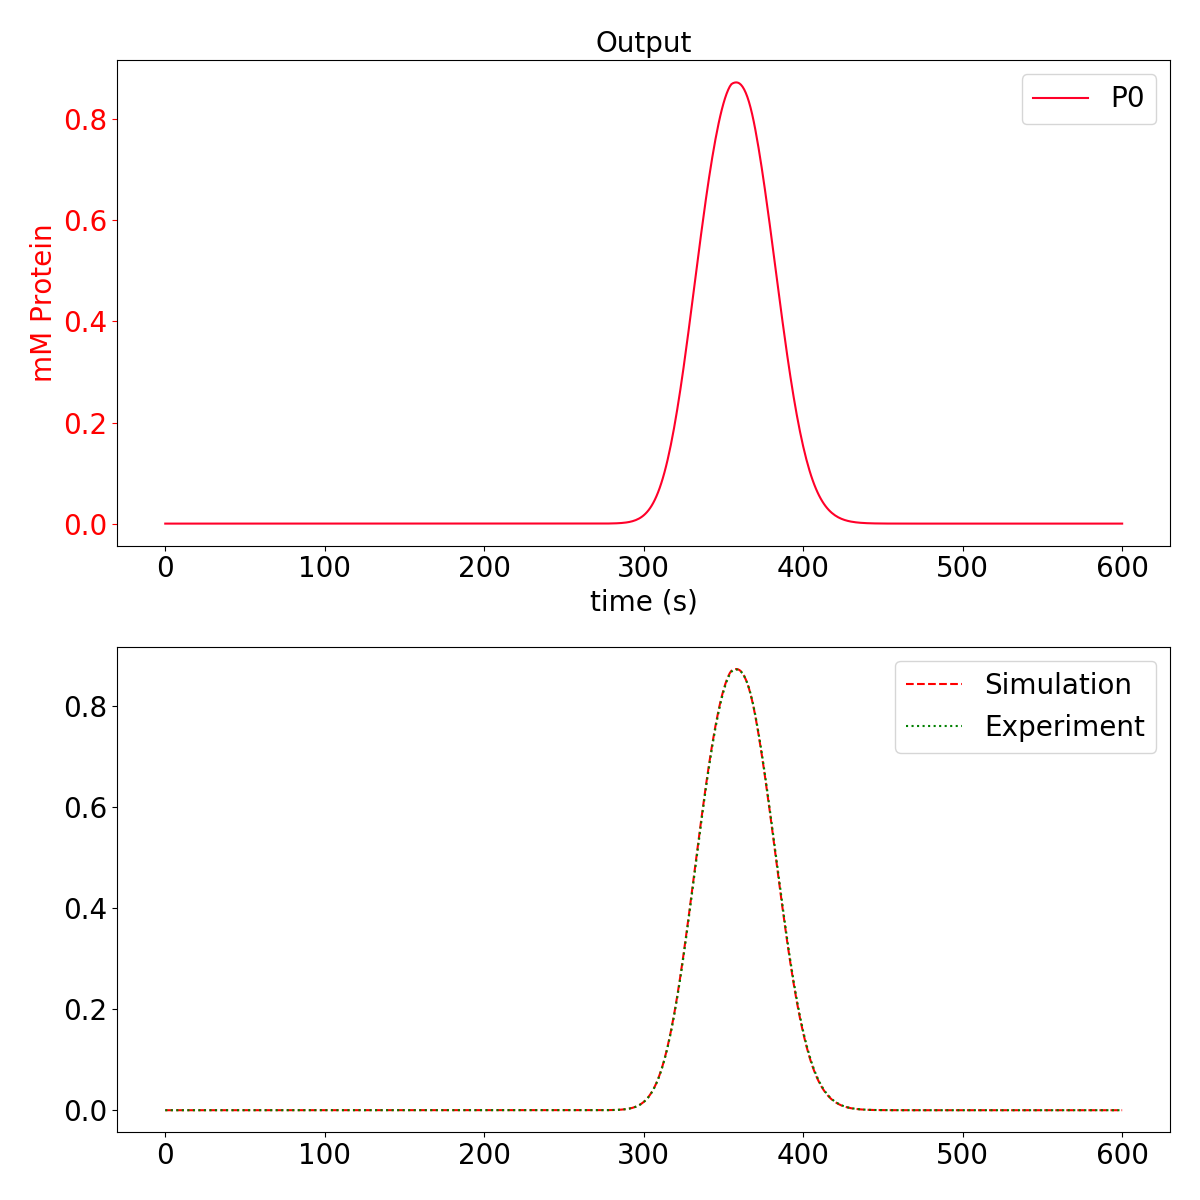

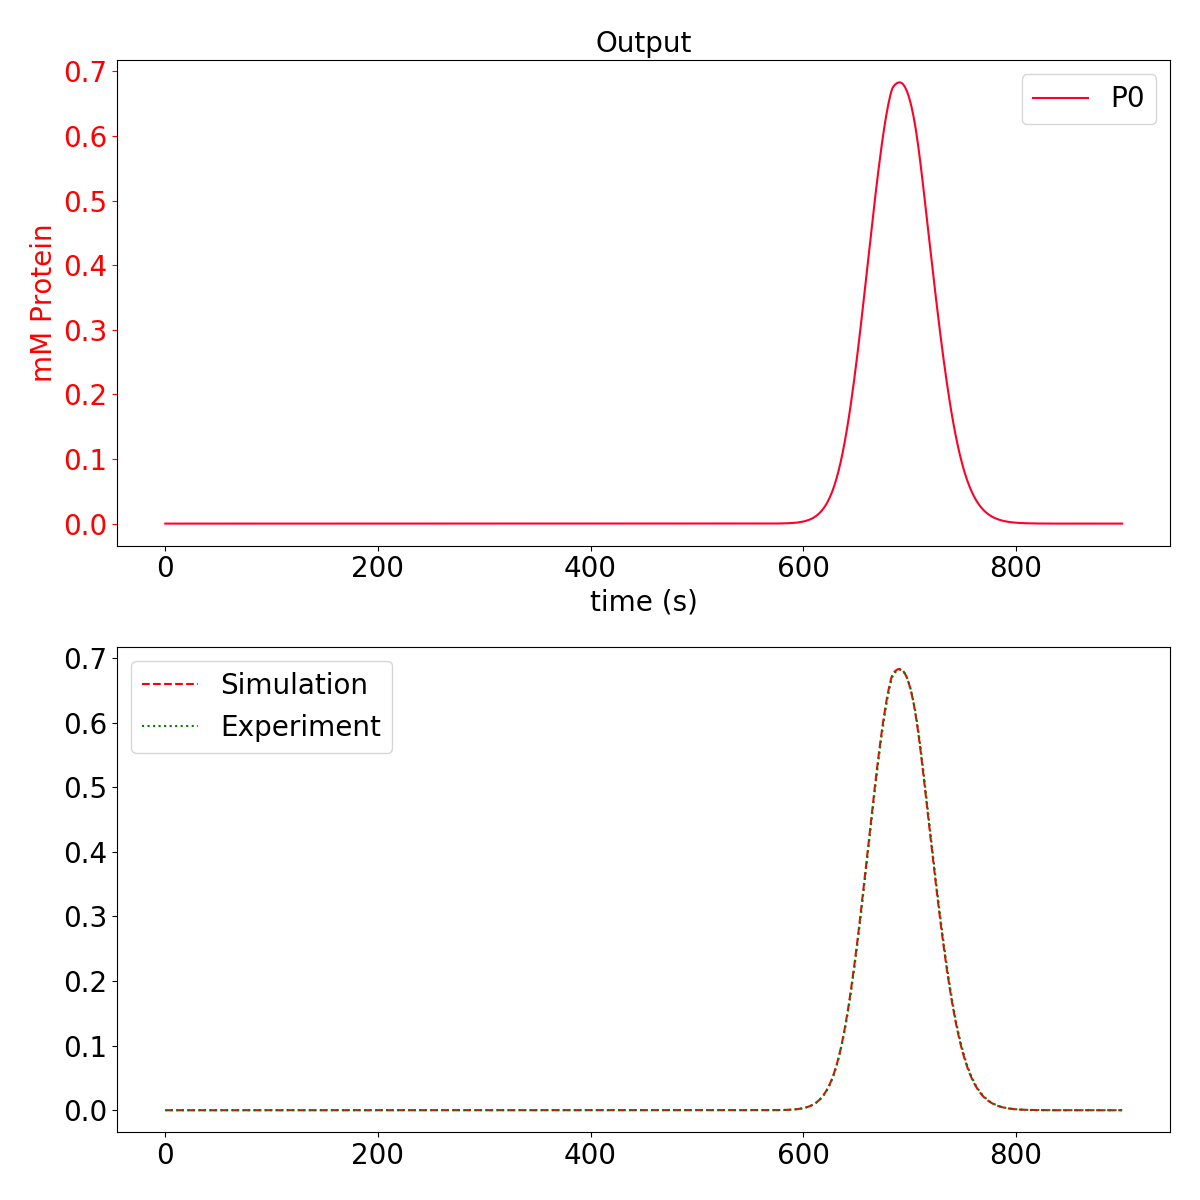

Best item 325b489bccfde6ba3d81b41216f93eb5 for meta score(s) Min Score


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,exp1_Pulse_Shape,exp1_Pulse_Time,exp2_Pulse_Shape,exp2_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
1,Mon Sep 30 17:06:42 2019,325b489bccfde6ba3d81b41216f93eb5,EVO,NaN,1.990354e-07,0.369818,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000022


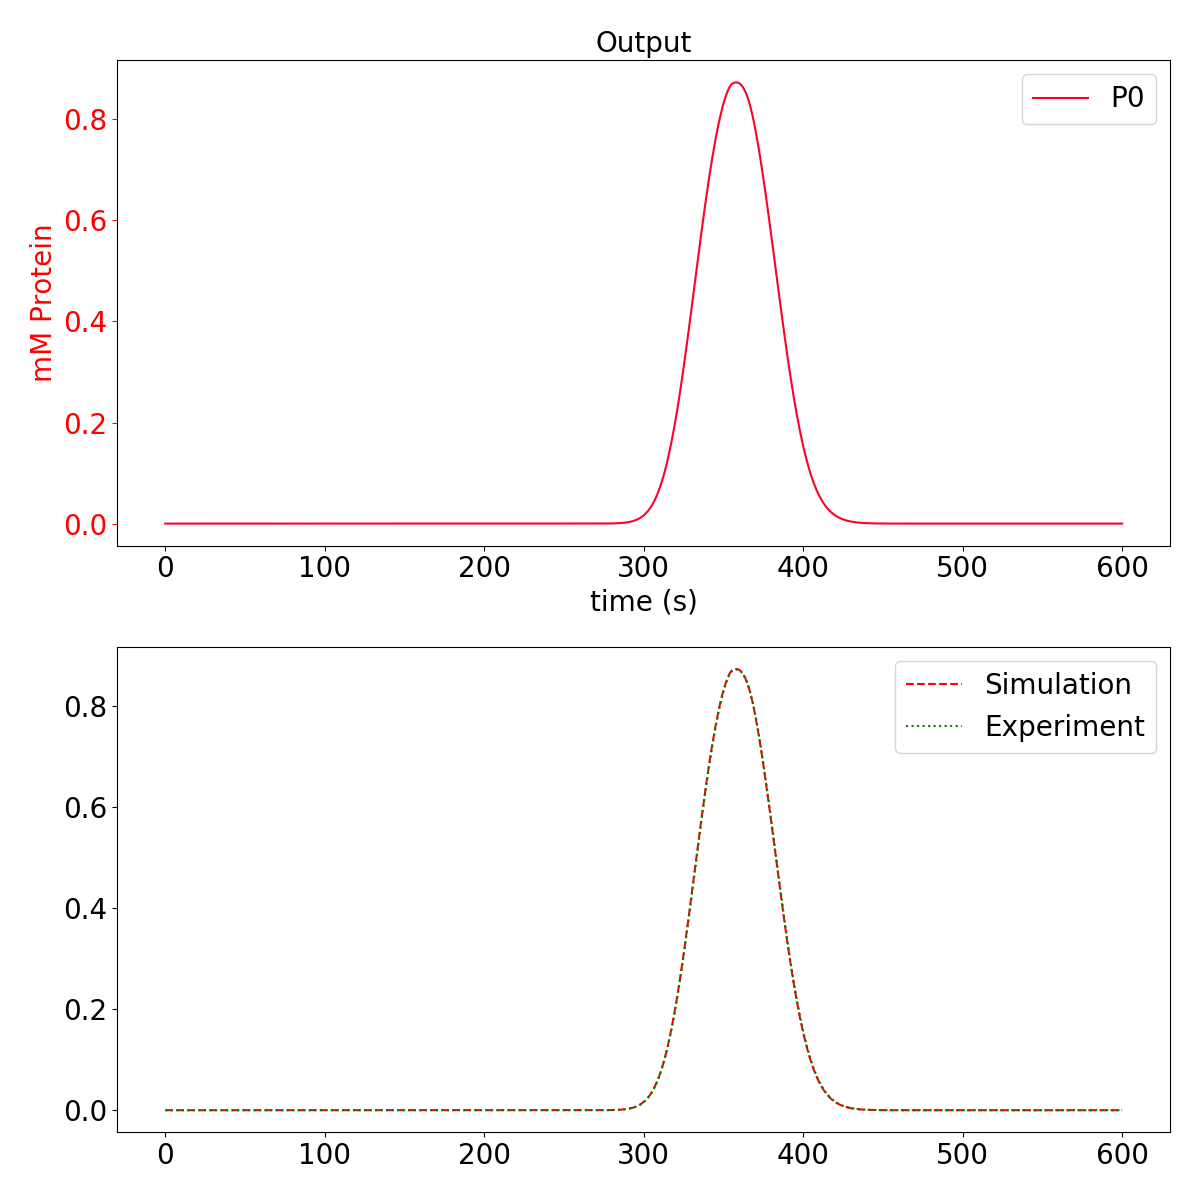

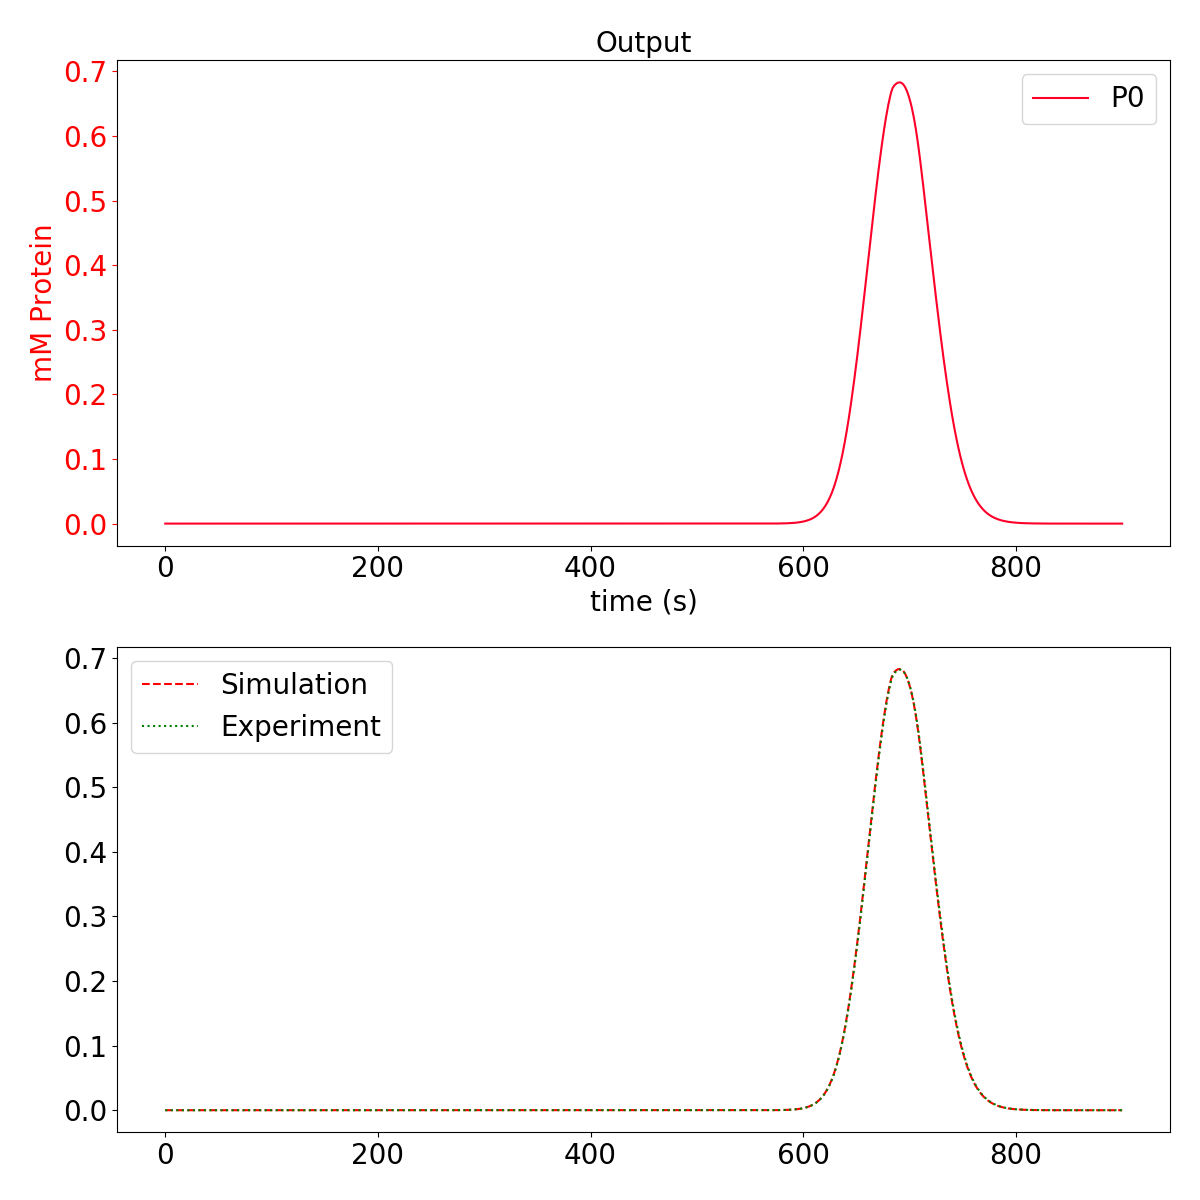

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.99e-07   error: 0.52%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.062%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.99e-07   error: 0.48%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.049%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.99e-07   error: 0.52%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.062%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 1.99e-07   error: 0.52%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.062%




In [11]:
sim_multiple = Match(match_file.as_posix())

resultDirMultiple = Path(match_multiple.baseDir) / match_multiple.resultsDir
print("Your results are located at", resultDirMultiple.as_posix(), '\n\n')

#If you want to delete the fitting process to start over remove the # from the next line and re-run this cell
deleteResultDir(resultDirMultiple)

sim_multiple.start_sim()

sim_multiple.plot_best()
best ,score, best_score = sim_multiple.get_best()
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])
for key,value in best_score.items():
    print("Method: %s" % key)
    for name, val, true_value in zip(sim_multiple.cache.parameter_headers, value, true_values):
        print("%s = %.2e   error: %.2g%%" % (name, val, numpy.abs(val-true_value)/val*100))
    print('\n')

# Multiple components
Dealing with multiple components is only slightly more complex. For this example I will take the Dextran pulse example and add a second component to it with a different concentration. After that we will look at how to fit the system with a score for each component.

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_5/multiple_components/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


C:\Users\kosh_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


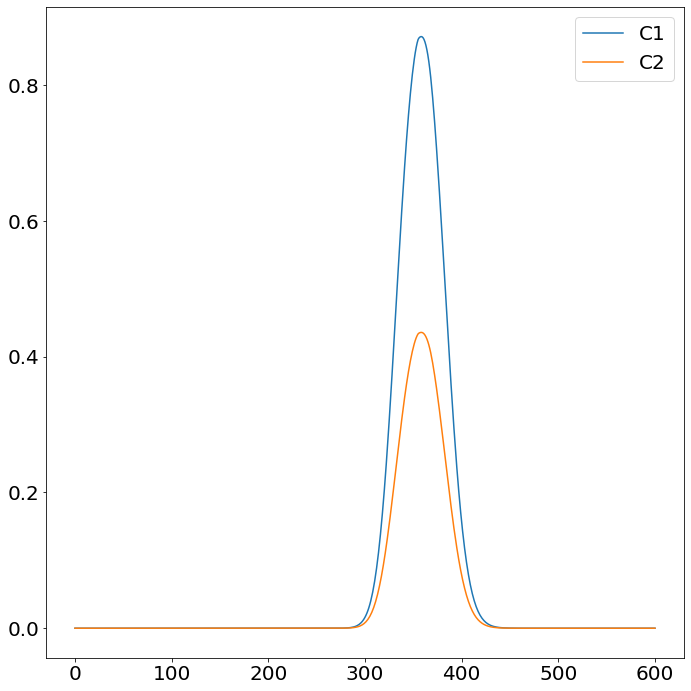

In [12]:
comps_dir = lesson_5 / "multiple_components"
comps_dir.mkdir(exist_ok = True)

simple = Cadet()

#give a filename for where the simulation should be saved
simple.filename = (lesson_1 / "simple_example" / 'example.h5').as_posix()

simple.load()

simple.filename = (comps_dir / 'example.h5').as_posix()

#add a second component, many small things change with this

simple.root.input.model.unit_000.ncomp = 2

#const_coeff + lin_coeff*t + quad_coeff*t^2 + cube_coeff*t^3
simple.root.input.model.unit_000.sec_000.const_coeff = [1.0, 0.5]
simple.root.input.model.unit_000.sec_000.lin_coeff =   [0.0, 0.0]
simple.root.input.model.unit_000.sec_000.quad_coeff =  [0.0, 0.0]
simple.root.input.model.unit_000.sec_000.cube_coeff =  [0.0, 0.0]

simple.root.input.model.unit_000.sec_001.const_coeff = [0.0, 0.0]
simple.root.input.model.unit_000.sec_001.lin_coeff =   [0.0, 0.0]
simple.root.input.model.unit_000.sec_001.quad_coeff =  [0.0, 0.0]
simple.root.input.model.unit_000.sec_001.cube_coeff =  [0.0, 0.0]

simple.root.input.model.unit_002.ncomp = 2

simple.root.input.model.unit_001.ncomp = 2
simple.root.input.model.unit_001.init_c = [0.0, 0.0]
simple.root.input.model.unit_001.init_q = [0.0, 0.0]
simple.root.input.model.unit_001.film_diffusion = [0.0, 0.0]

simple.root.input.model.unit_001.discretization.nbound = [0, 0]

#save the simulation
simple.save()

#run the simulation
data = simple.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    simple.load()
    
    times = simple.root.output.solution.solution_times
    values1 = simple.root.output.solution.unit_002.solution_outlet_comp_000
    values2 = simple.root.output.solution.unit_002.solution_outlet_comp_001
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times, values1, label='C1')
    plt.plot(times, values2, label='C2')
    plt.legend()
    plt.show()
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times,
                        values1]).transpose()
    data.to_csv((comps_dir / 'example_c1.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([times,
                        values2]).transpose()
    data.to_csv((comps_dir / 'example_c2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create a configuration file

In this case we are matching to a single experiment with two components but using the same two input variables.

In [13]:
match_comps = Dict(match.copy())
match_comps.CADETPath = cadet_path.as_posix()
match_comps.baseDir = comps_dir.as_posix()
match_comps.resultsDir = 'fit_nsga3_comps'


experiment1 = Dict()
experiment1.csv = "example_c1.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'
feature1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
feature1.csv = "example_c1.csv"

feature2 = Dict()
feature2.name = "Pulse"
feature2.type = 'DextranShape'
feature2.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_001"
feature2.csv = "example_c2.csv"

experiment1.features = [feature1,]

match_comps.experiments = [experiment1,]

match_file = comps_dir / 'example_nsga3_multiple.json'

with (match_file).open('w') as json_file:
    json.dump(match_comps.to_dict(), json_file, indent='\t')

## Run parameter estimation

Your results are located at F:/temp/cadet_tutorial/lesson_5/multiple_components/fit_nsga3_comps 


[2019-09-30 17:08:39,271] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-09-30 17:08:39,271] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-09-30 17:08:39,271] launcher  INFO    Worker distribution: 

[2019-09-30 17:08:39,271] launcher  INFO       127.0.0.1:	11 + origin

[2019-09-30 17:08:45,574] util      (b'127.0.0.1:64307') INFO    Generation: -1 	Population: 24 	Average Score: 0.962 	Best: 0.991 	Minimum Score: 0.932 	Best: 0.988 	Product Score: 0.961 	Best: 0.991

[2019-09-30 17:08:47,207] util      (b'127.0.0.1:64307') INFO    Generation: 0 	Population: 24 	Average Score: 0.953 	Best: 0.991 	Minimum Score: 0.911 	Best: 0.988 	Product Score: 0.951 	Best: 0.991

[2019-09-30 17:08:48,656] util      (b'127.0.0.1:64307') INFO    Generation: 1 	Populatio

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
0,Mon Sep 30 17:09:26 2019,a33681bee8cb6cd61ed740b073ce26e8,GRAD,NaN,1.999294e-07,0.369994,1.0,1.0,1.0,1.0,1.0,2.091554e-11


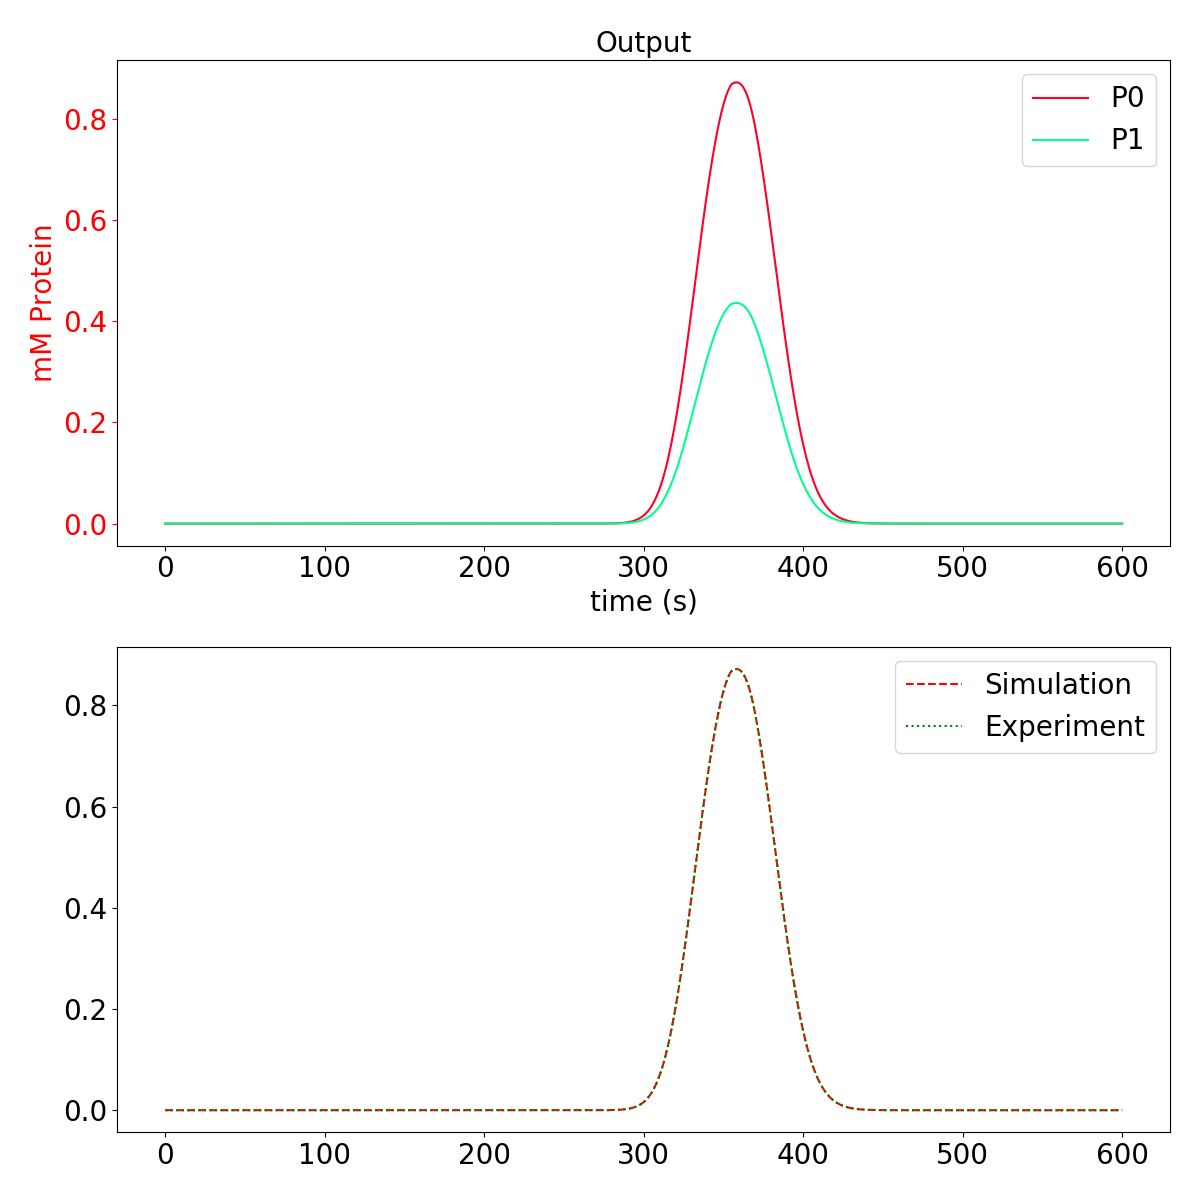

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.035%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.0016%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.035%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.0016%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.035%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.0016%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.035%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.0016%




In [14]:
sim_comps = Match(match_file.as_posix())

resultDirComps = Path(match_comps.baseDir) / match_comps.resultsDir
print("Your results are located at", resultDirComps.as_posix(), '\n\n')

#If you want to delete the fitting process to start over remove the # from the next line and re-run this cell
deleteResultDir(resultDirComps)

sim_comps.start_sim()

sim_comps.plot_best()
best ,score, best_score = sim_comps.get_best()
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])
for key,value in best_score.items():
    print("Method: %s" % key)
    for name, val, true_value in zip(sim_comps.cache.parameter_headers, value, true_values):
        print("%s = %.2e   error: %.2g%%" % (name, val, numpy.abs(val-true_value)/val*100))
    print('\n')

# Fractionation

Fractionation is when you collect a series of samples from the outlet and measure the concentration of each component. Usually there are 5-10 samples avaiable and a summation UV signal. These are some of the most complex systems to fit.

We will fractionate the multiple components example and fit to the summation UV signal and fractionation data.

The first step is to take our existing multiple component simulation that we just used to create a sum signal and fractionation data. No changes will be made to the simulation, we just need to read the data again.

The fraction graph generated uses lines to join points but they are not actualy continuous. Based on experience these graphs are much harder to follow with the eye if you don't have lines connecting the data points.

No handles with labels found to put in legend.
C:\Users\kosh_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\kosh_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


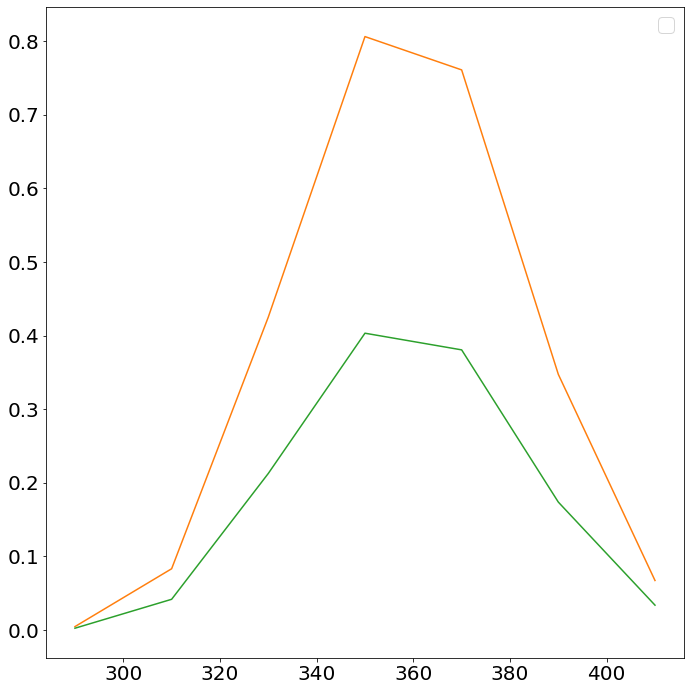

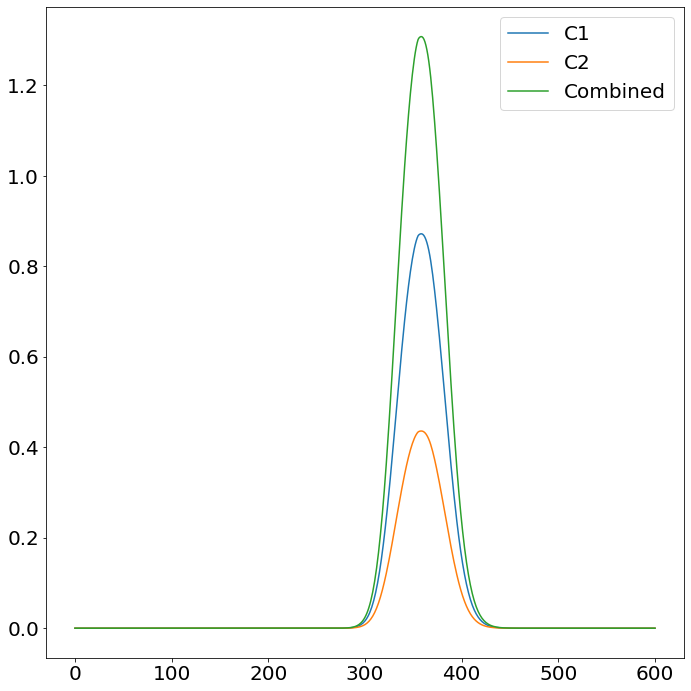

In [15]:
simple = Cadet()

simple.filename = (comps_dir / 'example.h5').as_posix()

simple.load()


times = simple.root.output.solution.solution_times
values1 = simple.root.output.solution.unit_002.solution_outlet_comp_000
values2 = simple.root.output.solution.unit_002.solution_outlet_comp_001

start_seq = [280, 300, 320, 340, 360, 380, 400]
stop_seq = [300, 320, 340, 360, 380, 400, 420]

min_seq = (numpy.array(start_seq) + numpy.array(stop_seq))/2.0


frac1 = fractionate(start_seq, stop_seq, times, values1)
frac2 = fractionate(start_seq, stop_seq, times, values2)

plt.figure(figsize=[10,10])
plt.plot(min_seq, frac1, 'C1')
plt.plot(min_seq, frac2, 'C2')
plt.legend()
plt.show()

df = pandas.DataFrame.from_dict({'Start':start_seq, 'Stop':stop_seq, '0':frac1, '1':frac2})
df.to_csv((comps_dir / 'example_fractions.csv').as_posix(), columns=('Start', 'Stop', '0', '1'), index=False)


#plot the simulation
plt.figure(figsize=[10,10])
plt.plot(times, values1, label='C1')
plt.plot(times, values2, label='C2')
plt.plot(times, values1 + values2, label='Combined')
plt.legend()
plt.show()

#write the chromatogram data out to a csv file
data = pandas.DataFrame([times,
                    values1+values2]).transpose()
data.to_csv((comps_dir / 'example_combined.csv').as_posix(), index=False, header=False)

## Create a configuration file
There are only a few changes that need to be made to the file to deal with fractionation.

Since we are dealing with the sum signal we need to compare that with the sum of components in our simulation. With CADETMatch you can make isotherm a list and the software will add up all the values in the list. In this case we are adding up component 0 and component 1 with

```python
feature1.isotherm = ["/output/solution/unit_002/SOLUTION_OUTLET_COMP_000", "/output/solution/unit_002/SOLUTION_OUTLET_COMP_001"]
```

The next thing is to create a fractionation setup which looks like

```python
feature = Dict()
feature.name = "Frac"
feature.type = 'fractionationSlide'
feature.fraction_csv = "example_fractions.csv"
feature.unit_name = 'unit_002'
```

or in json it looks like

```json
{
    "name": "Frac",
    "type": 'fractionationSlide',
    "fraction_csv": "example_fractions.csv",
    "unit_name": 'unit_002'
}
```

fraction_csv needs to be the path to the csv file that has fractionation data
unit_name needs to be the name of the unit operation we are trying to fractionate in the system.

In [16]:
match_frac = Dict(match.copy())
match_frac.CADETPath = cadet_path.as_posix()
match_frac.baseDir = comps_dir.as_posix()
match_frac.resultsDir = 'fit_nsga3_frac'

experiment1 = Dict()
experiment1.csv = "example_c1.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'Shape'
feature1.isotherm = ["/output/solution/unit_002/SOLUTION_OUTLET_COMP_000", "/output/solution/unit_002/SOLUTION_OUTLET_COMP_001"]
feature1.csv = "example_combined.csv"

feature2 = Dict()
feature2.name = "Frac"
feature2.type = 'fractionationSlide'
feature2.fraction_csv = "example_fractions.csv"
feature2.unit_name = 'unit_002'

experiment1.features = [feature1, feature2]

match_frac.experiments = [experiment1,]

match_file = comps_dir / 'example_nsga3_fractionation.json'

with (match_file).open('w') as json_file:
    json.dump(match_frac.to_dict(), json_file, indent='\t')

## Run parameter estimation
Fractionation is a hard problem and it can take significantly longer to fit than if full chromatograms are available. There is less data available and so it is harder to tell if an answer is better or worse.

Your results are located at F:/temp/cadet_tutorial/lesson_5/multiple_components/fit_nsga3_frac 


[2019-09-30 17:09:52,402] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-09-30 17:09:52,402] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-09-30 17:09:52,402] launcher  INFO    Worker distribution: 

[2019-09-30 17:09:52,402] launcher  INFO       127.0.0.1:	11 + origin

[2019-09-30 17:09:59,026] util      (b'127.0.0.1:60713') INFO    Generation: -1 	Population: 24 	Average Score: 0.963 	Best: 0.995 	Minimum Score: 0.883 	Best: 0.985 	Product Score: 0.961 	Best: 0.995

[2019-09-30 17:10:01,109] util      (b'127.0.0.1:60713') INFO    Generation: 0 	Population: 24 	Average Score: 0.964 	Best: 0.995 	Minimum Score: 0.888 	Best: 0.985 	Product Score: 0.962 	Best: 0.995

[2019-09-30 17:10:02,973] util      (b'127.0.0.1:60713') INFO    Generation: 1 	Population

[2019-09-30 17:11:46,010] generate_corner_graphs (b'127.0.0.1:55580') INFO    graphing directory F:\temp\cadet_tutorial\lesson_5\multiple_components

[2019-09-30 17:11:46,011] generate_corner_graphs (b'127.0.0.1:55580') INFO    plotting corner plots

[2019-09-30 17:11:46,015] generate_corner_graphs (b'127.0.0.1:55580') INFO    graphing remove 0 points

[2019-09-30 17:12:00,304] launcher  (127.0.0.1:55180) INFO    Root process is done.

[2019-09-30 17:12:00,305] launcher  (127.0.0.1:55180) INFO    Finished cleaning spawned subprocesses.

[2019-09-30 17:12:00,323] match     (b'127.0.0.1:60713') INFO    altFeatures False

[2019-09-30 17:12:00,324] match     (b'127.0.0.1:60713') INFO    altFeatureNames []

[2019-09-30 17:12:00,324] match     (b'127.0.0.1:60713') INFO    Sysem has finished

[2019-09-30 17:12:00,324] match     (b'127.0.0.1:60713') INFO    The total runtime was 124.00047373771667 seconds

[2019-09-30 17:12:01,075] launcher  (127.0.0.1:54887) INFO    Root process is done.

[20

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Similarity,main_Pulse_Value,main_Pulse_Time,main_Pulse_Derivative_Similarity,...,main_Frac_Component_0_Similarity,main_Frac_Component_0_Time,main_Frac_Component_0_Value,main_Frac_Component_1_Similarity,main_Frac_Component_1_Time,main_Frac_Component_1_Value,Product Root Score,Min Score,Mean Score,SSE
1,Mon Sep 30 17:11:33 2019,36b1e59a40f2cbe6cfaa5ab4521ae701,GRAD,NaN,2.000000e-07,0.37,1.0,1.0,0.999997,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999997,1.0,1.119062e-17


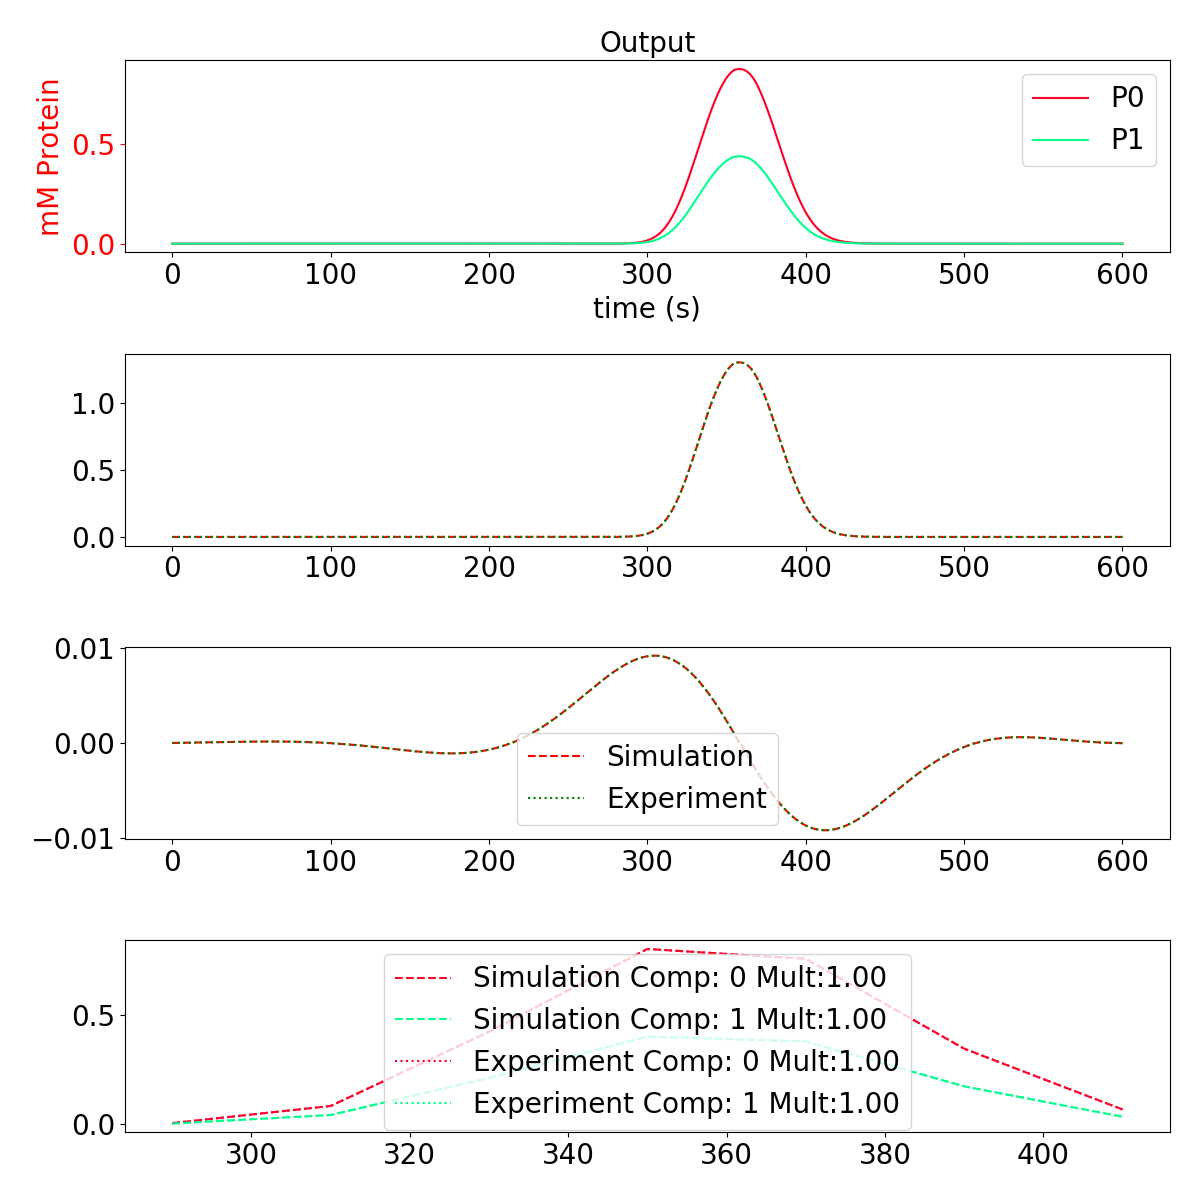

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 1.8e-07%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 3.3e-10%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 1.8e-07%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 3.3e-10%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 1.8e-07%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 3.3e-10%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 1.8e-07%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 3.3e-10%




In [17]:
sim_frac = Match(match_file.as_posix())

resultDirFrac = Path(match_frac.baseDir) / match_frac.resultsDir
print("Your results are located at", resultDirFrac.as_posix(), '\n\n')

#If you want to delete the fitting process to start over remove the # from the next line and re-run this cell
deleteResultDir(resultDirFrac)

sim_frac.start_sim()

sim_frac.plot_best()
best ,score, best_score = sim_frac.get_best()
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])
for key,value in best_score.items():
    print("Method: %s" % key)
    for name, val, true_value in zip(sim_frac.cache.parameter_headers, value, true_values):
        print("%s = %.2e   error: %.2g%%" % (name, val, numpy.abs(val-true_value)/val*100))
    print('\n')